# ARF stop codon bias for core genes (supplementary)

To identify core genes, gtdbtk (v1.5.0) was used.

Reference database was downloaded as follows:

```{bash}
# on May. 24, 2021, at /nfs_share/yamanouchi/gtdb
wget https://data.gtdb.ecogenomic.org/releases/release202/202.0/auxillary_files/gtdbtk_r202_data.tar.gz
tar xvzf gtdbtk_r202_data.tar.gz
rm gtdbtk_r202_data.tar.gz
```

`gtdbtk identify` was performed under the following configurations (on May. 31, 2021):

```{bash}
docker-compose run --rm gtdbtk identify --genome_dir /data/genomic_fna --out_dir /data/gtdbtk --cpus 100
```

- docker-compose.yml (partial)
    ```
    gtdbtk:
    image: ecogenomic/gtdbtk:1.5.0
    volumes:
      - ./data:/data
      - /nfs_share/yamanouchi/gtdb/release202:/refdata
    ```


In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import reverse_complement
from collections import Counter
from itertools import product
from tqdm.notebook import tqdm
from pyscripts.config import path2
from pyscripts.genomeutil import sliding, bac_translate

In [2]:
# no error
!cat $path2.data/gtdbtk/gtdbtk.failed_genomes.tsv

In [3]:
markers_summary = pd.read_csv(
    path2.data/'gtdbtk'/'gtdbtk.bac120.markers_summary.tsv', 
    sep='\t', index_col=0
)

In [4]:
path2markers = path2.data/'gtdbtk'/'identify'/'intermediate_results'/'marker_genes'

def get_tophits(ncbi_gcf):
    tophits = pd.concat([
        pd.read_csv(path2markers/ncbi_gcf/f'{ncbi_gcf}_pfam_tophit.tsv',sep='\t'),
        pd.read_csv(path2markers/ncbi_gcf/f'{ncbi_gcf}_tigrfam_tophit.tsv',sep='\t')
    ])
    tophits = pd.concat([
        tophits['Gene Id'],
        tophits['Top hits (Family id,e-value,bitscore)'].str.split(',', expand=True),
    ], axis=1).rename({'Gene Id':'gene_id', 0:'family_id', 1:'evalue', 2:'bitscore'}, axis=1).set_index(['family_id', 'gene_id'])
    return tophits


In [5]:
fill_list = lambda d: d if type(d) is list else []
markers_lists = markers_summary['list_unique_genes'].str.split(',').apply(fill_list) + \
               markers_summary['list_multiple_genes'].str.split(',').apply(fill_list) + \
               markers_summary['list_multiple_unique_genes'].str.split(',').apply(fill_list)

For the CDSs annotated by Prodigal inside gtdbtk, we calculated the bias of the ARF stop codon in the same way as in the main analysis, except that overlap was not taken into account.

In [6]:
codon_idx   = [*map(''.join, product('ACGT', repeat=3))]
bicodon_idx = [*map(''.join, product('ACGT', repeat=6))]
 
def count_freqs_markers(ncbi_gcf):
    tophits  = get_tophits(ncbi_gcf)
    families = markers_lists[ncbi_gcf]
    bac120   = set(tophits.loc[families].index.get_level_values(1))
    
    bac120_codons   = pd.DataFrame(index=codon_idx, dtype=pd.Int32Dtype())
    bac120_bicodons = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())
    all_codons   = pd.DataFrame(index=codon_idx, dtype=pd.Int32Dtype())
    all_bicodons = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())
    
    for rec in SeqIO.parse(path2markers/ncbi_gcf/f'{ncbi_gcf}_protein.fna', 'fasta'):
        if rec.id in bac120:
            bac120_codons[rec.id]   = pd.Series(Counter(sliding(str(rec.seq), 3, 3)), dtype=pd.Int32Dtype())
            bac120_bicodons[rec.id] = pd.Series(Counter(sliding(str(rec.seq), 6, 3)), dtype=pd.Int32Dtype())
        all_codons[rec.id]   = pd.Series(Counter(sliding(str(rec.seq), 3, 3)), dtype=pd.Int32Dtype())
        all_bicodons[rec.id] = pd.Series(Counter(sliding(str(rec.seq), 6, 3)), dtype=pd.Int32Dtype())

    return ncbi_gcf[5:], (bac120_codons.T.sum(), bac120_bicodons.T.sum()), (all_codons.T.sum(), all_bicodons.T.sum())


In [7]:
bac120_codons_summary   = pd.DataFrame(index=codon_idx  , dtype=pd.Int32Dtype())
bac120_bicodons_summary = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())
all_codons_summary   = pd.DataFrame(index=codon_idx  , dtype=pd.Int32Dtype())
all_bicodons_summary = pd.DataFrame(index=bicodon_idx, dtype=pd.Int32Dtype())

from multiprocessing import Pool

with Pool(100) as pool:
    for acc, (bac120_codons, bac120_bicodons), (all_codons, all_bicodons) in tqdm(
        pool.imap_unordered(count_freqs_markers, markers_lists.index),
        total=len(markers_summary)
    ):
        bac120_codons_summary[acc]   = bac120_codons
        bac120_bicodons_summary[acc] = bac120_bicodons
        all_codons_summary[acc]      = all_codons
        all_bicodons_summary[acc]    = all_bicodons
    

  0%|          | 0/2624 [00:00<?, ?it/s]

In [8]:
bac120_codon_usage  = bac120_codons_summary / bac120_codons_summary.groupby(bac_translate).transform('sum')
obs_bac120_bicodons = bac120_bicodons_summary
exp_bac120_bicodons = bac120_bicodons_summary.groupby(bac_translate).transform('sum') \
                       * bac120_bicodons_summary.index.to_series().str[:3].apply(lambda c: bac120_codon_usage.loc[c]) \
                       * bac120_bicodons_summary.index.to_series().str[3:].apply(lambda c: bac120_codon_usage.loc[c])

all_codon_usage  = all_codons_summary / all_codons_summary.groupby(bac_translate).transform('sum')
obs_all_bicodons = all_bicodons_summary
exp_all_bicodons = all_bicodons_summary.groupby(bac_translate).transform('sum') \
                    * all_bicodons_summary.index.to_series().str[:3].apply(lambda c: all_codon_usage.loc[c]) \
                    * all_bicodons_summary.index.to_series().str[3:].apply(lambda c: all_codon_usage.loc[c])

In [9]:
fw1 = lambda bc: bac_translate(bc[1:4])
fw2 = lambda bc: bac_translate(bc[2:5])
rc1 = lambda bc: bac_translate(reverse_complement(bc[1:4]))
rc2 = lambda bc: bac_translate(reverse_complement(bc[2:5]))

In [26]:
Z_stop_bac120, Z_stop_all = pd.DataFrame(dtype=float), pd.DataFrame(dtype=float)
d_stop_bac120, d_stop_all = pd.DataFrame(dtype=float), pd.DataFrame(dtype=float)

for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
    obs_bac120_aa = obs_bac120_bicodons.groupby(arf).sum()
    exp_bac120_aa = exp_bac120_bicodons.groupby(arf).sum()
    assert np.isclose(obs_bac120_aa.sum(), exp_bac120_aa.sum()).all()
    N_bac120 = exp_bac120_aa.sum()
    obs_bac120_stop, exp_bac120_stop = obs_bac120_aa.loc['*'], exp_bac120_aa.loc['*']
    Z_stop_bac120[frame] = (obs_bac120_stop - exp_bac120_stop) / np.sqrt((N_bac120 * exp_bac120_stop - exp_bac120_stop ** 2) / (N_bac120 - 1))
    d_stop_bac120[frame] = (obs_bac120_stop - exp_bac120_stop) / N_bac120
    
    obs_all_aa = obs_all_bicodons.groupby(arf).sum()
    exp_all_aa = exp_all_bicodons.groupby(arf).sum()
    assert np.isclose(obs_all_aa.sum(), exp_all_aa.sum()).all()
    N_all = exp_all_aa.sum()
    obs_all_stop, exp_all_stop = obs_all_aa.loc['*'], exp_all_aa.loc['*']
    Z_stop_all[frame] = (obs_all_stop - exp_all_stop) / np.sqrt((N_all * exp_all_stop - exp_all_stop ** 2) / (N_all - 1))
    d_stop_all[frame] = (obs_all_stop - exp_all_stop) / N_all
    

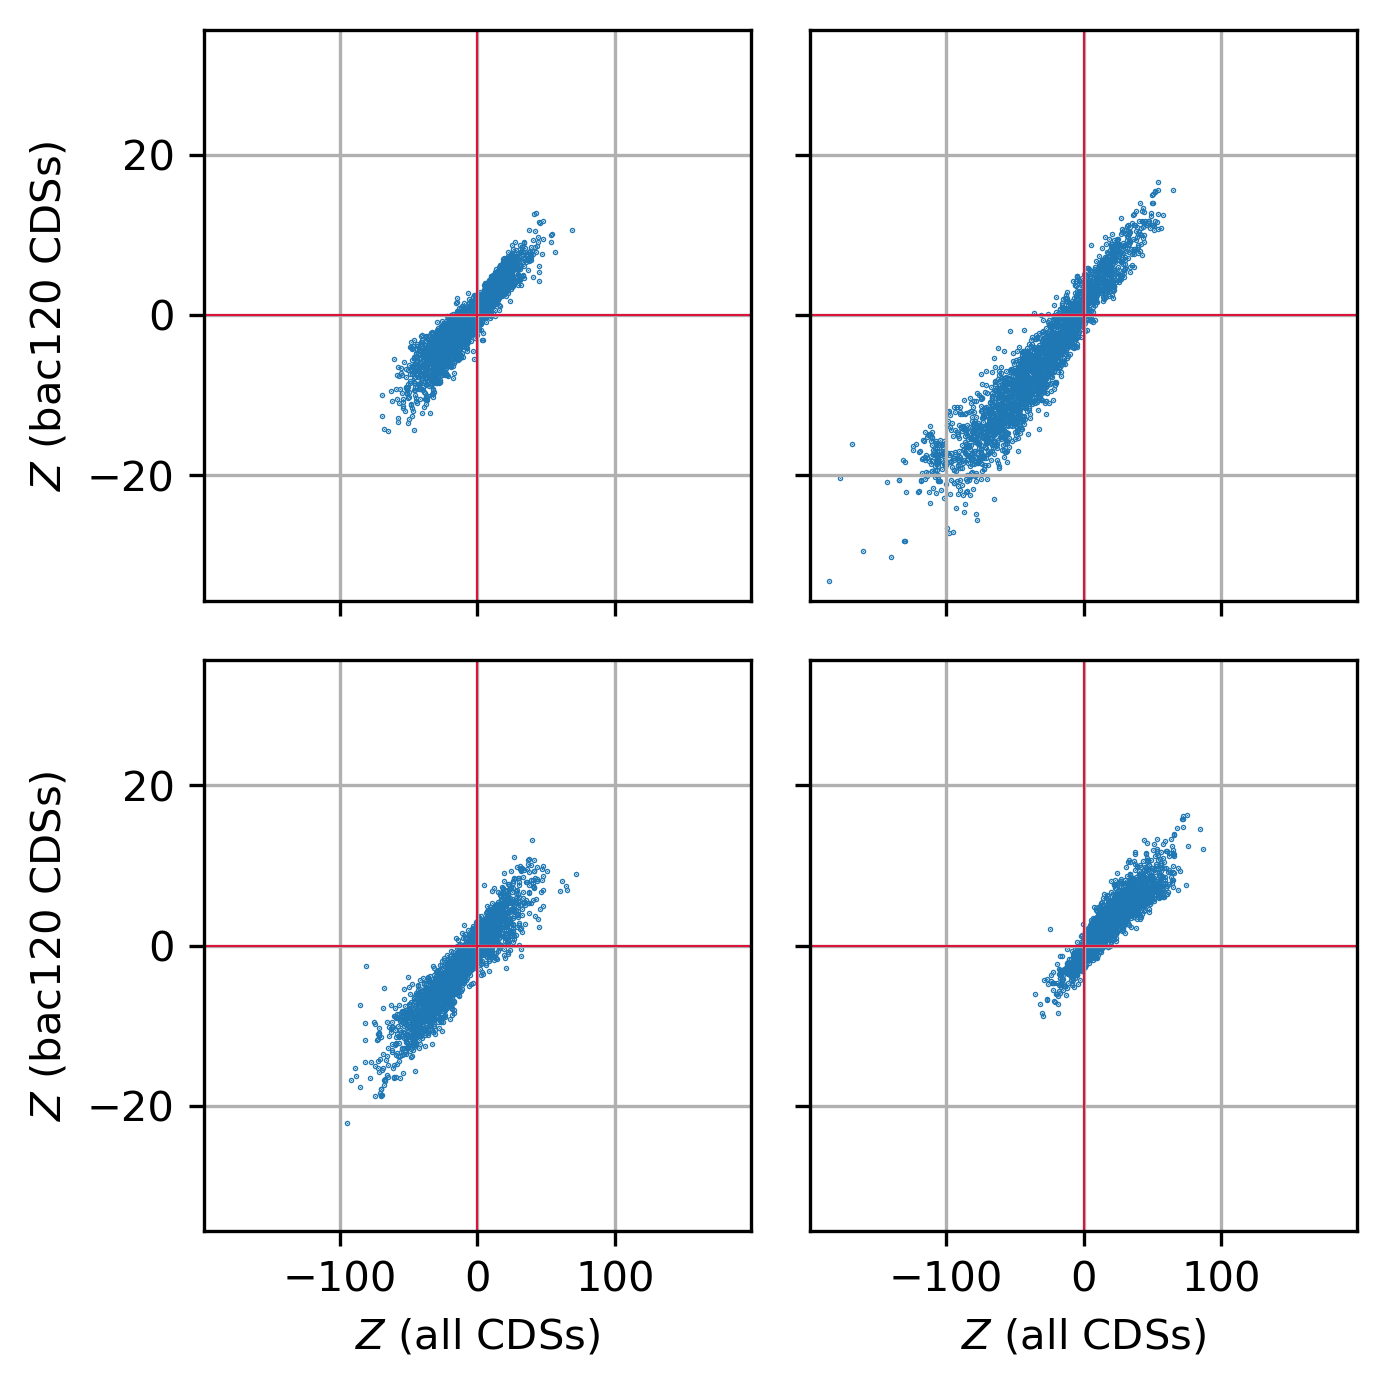

In [60]:
import matplotlib.pyplot as plt 

mm = 1 / 25.4
fig, axes = plt.subplots(2, 2, figsize=(120*mm, 120*mm), dpi=300, sharex=True, sharey=True)

for ax, frame in zip(axes.flatten(), ['+1','+2','-1','-2']):
    ax.scatter(Z_stop_all[frame], Z_stop_bac120[frame], s=0.1)
    ax.grid()
    ax.axhline(0, c='crimson', lw=0.5)
    ax.axvline(0, c='crimson', lw=0.5)
else:
    ax.set_xlim(-max(map(abs, ax.get_xlim())), max(map(abs, ax.get_xlim())))
    ax.set_ylim(-max(map(abs, ax.get_ylim())), max(map(abs, ax.get_ylim())))

for ax in axes[-1,:]: ax.set_xlabel('$Z$ (all CDSs)')
for ax in axes[:, 0]: ax.set_ylabel('$Z$ (bac120 CDSs)')
    
fig.tight_layout()

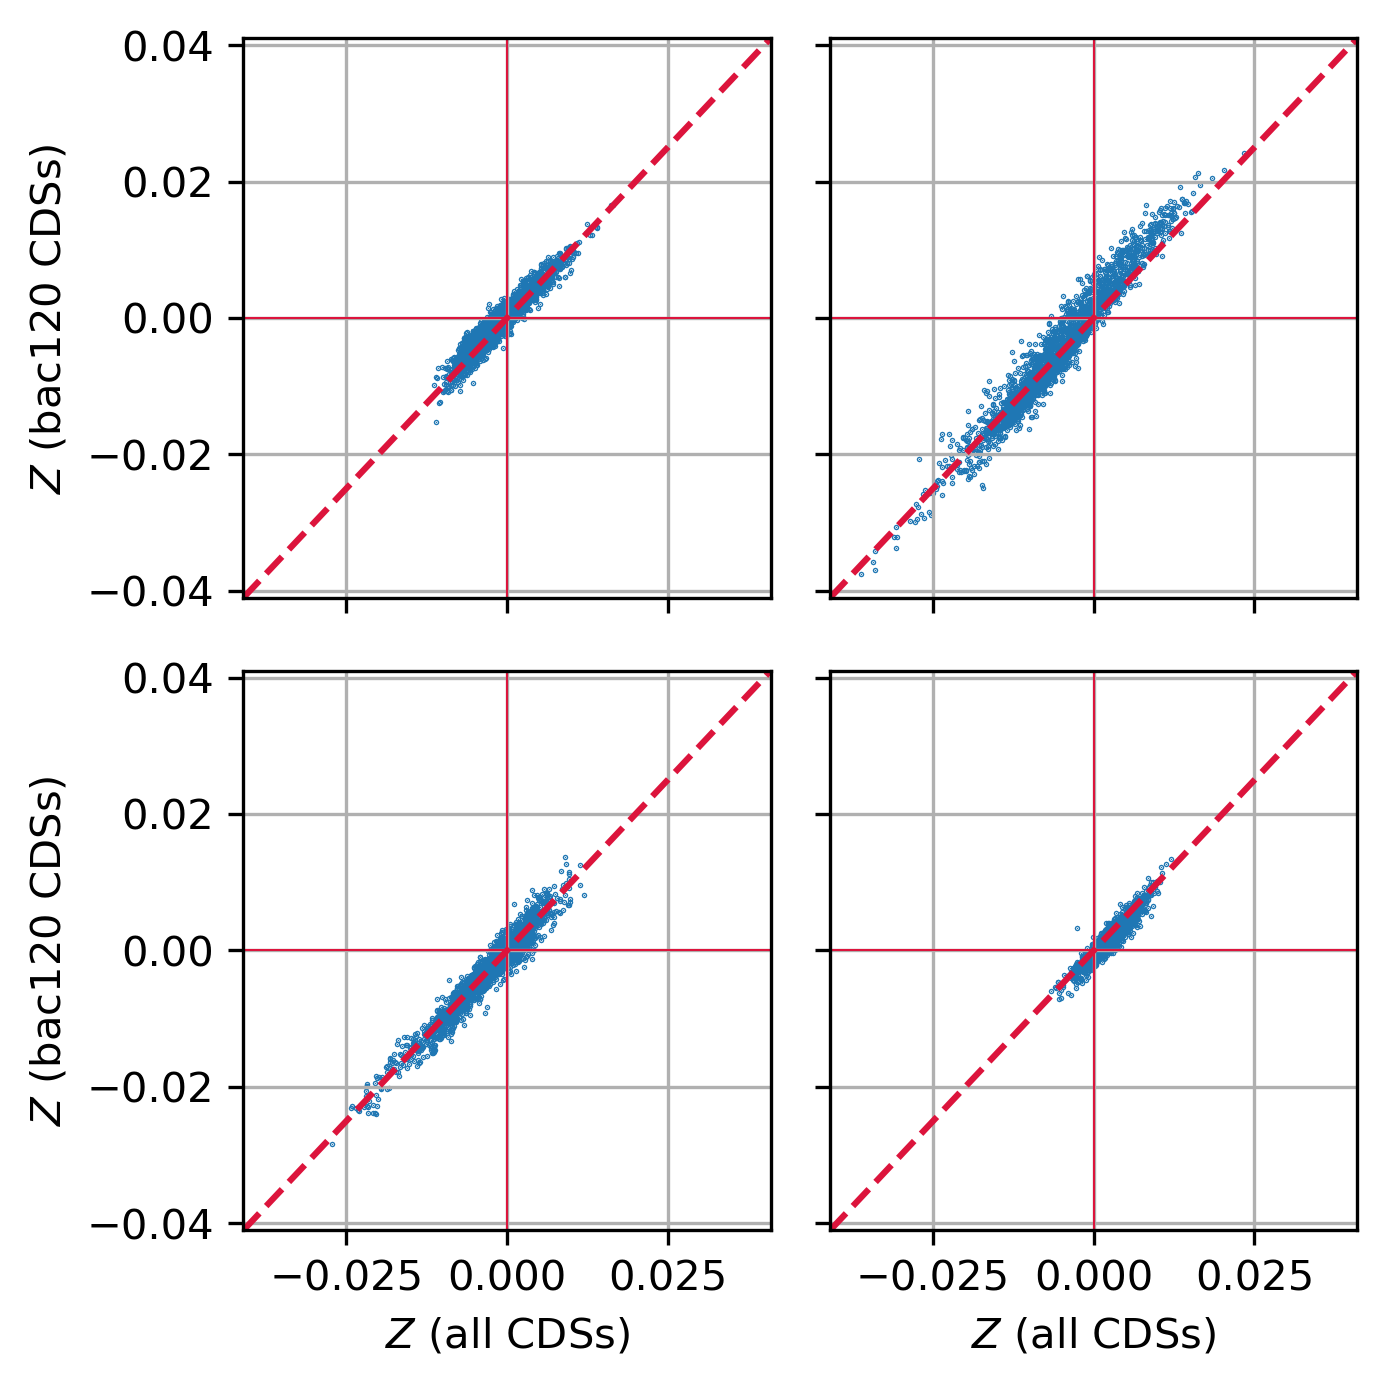

In [65]:
import matplotlib.pyplot as plt 

mm = 1 / 25.4
fig, axes = plt.subplots(2, 2, figsize=(120*mm, 120*mm), dpi=300, sharex=True, sharey=True)

for ax, frame in zip(axes.flatten(), ['+1','+2','-1','-2']):
    ax.scatter(d_stop_all[frame], d_stop_bac120[frame], s=0.1)
    ax.grid()
    ax.axhline(0, c='crimson', lw=0.5)
    ax.axvline(0, c='crimson', lw=0.5)
    
    ax.set_xlim(-0.041, 0.041)
    ax.set_ylim(-0.041, 0.041)
    ax.axline((-1,-1), (1,1), c='crimson', ls='--')
for ax in axes[-1,:]: ax.set_xlabel('$Z$ (all CDSs)')
for ax in axes[:, 0]: ax.set_ylabel('$Z$ (bac120 CDSs)')
    
fig.tight_layout()

- Figures will be revised.